# Drugs Reviews GloVe CNN with Sample Weights

In [1]:
import gensim
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, precision_recall_curve, average_precision_score
import gensim.downloader as api
from gensim.models import KeyedVectors
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from keras.models import Sequential
from sklearn.utils.class_weight import compute_sample_weight
from keras.callbacks import EarlyStopping
from keras.layers import Input, Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense, Concatenate
from keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.metrics import f1_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load the data

In [ ]:
X_train = pd.read_csv("/content/drive/MyDrive/Thesis/dataset/X_train.csv")['review']
y_train = pd.read_csv("/content/drive/MyDrive/Thesis/dataset/y_train.csv")['sentiment']

X_val = pd.read_csv("/content/drive/MyDrive/Thesis/dataset/X_val.csv")['review'].reset_index(drop=True)
y_val = pd.read_csv("/content/drive/MyDrive/Thesis/dataset/y_val.csv")['sentiment'].reset_index(drop=True)

X_test = pd.read_csv("/content/drive/MyDrive/Thesis/dataset/X_test.csv")['review'].reset_index(drop=True)
y_test = pd.read_csv("/content/drive/MyDrive/Thesis/dataset/y_test.csv")['sentiment'].reset_index(drop=True)

X_train = X_train.astype(str).dropna()
X_val = X_val.astype(str).dropna()
X_test = X_test.astype(str).dropna()

In [ ]:
embeddings_index = {}
with open('/content/drive/MyDrive/Thesis/GloVe/glove.6B.300d.txt', encoding='utf8') as f:
  for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

In [ ]:
tokenizer = Tokenizer(num_words=30000)
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_val = tokenizer.texts_to_sequences(X_val)
sequences_test = tokenizer.texts_to_sequences(X_test)

#Without Batch normalization

In [ ]:
X_train_pad = pad_sequences(sequences_train, maxlen=250, padding='post', truncating='post')
X_val_pad = pad_sequences(sequences_val, maxlen=250, padding='post', truncating='post')
X_test_pad = pad_sequences(sequences_test, maxlen=250, padding='post', truncating='post')

num_words = min(30000, len(tokenizer.word_index) + 1)
embedding_matrix = np.zeros((num_words, 300))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_dim = 300
sequence_input = Input(shape=(250,))
embedding_layer = Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=250, trainable=False)
embedded_sequences = embedding_layer(sequence_input)
drop_out_1 = Dropout(0.3, name='drop_out_1')(embedded_sequences)
conv_1 = Conv1D(64, 2, activation='relu', name='conv_1')(drop_out_1)
gmp_1 = GlobalMaxPooling1D(name='gmp_1')(conv_1)
conv_2 = Conv1D(64, 3, activation='relu', name='conv_2')(drop_out_1)
gmp_2 = GlobalMaxPooling1D(name='gmp_2')(conv_2)
conv_3 = Conv1D(64, 5, activation='relu', name='conv_3')(drop_out_1)
gmp_3 = GlobalMaxPooling1D(name='gmp_3')(conv_3)
concat = Concatenate()([gmp_1, gmp_2, gmp_3])
drop_out_2 = Dropout(0.3, name='drop_out_2')(concat)
dense = Dense(128, activation='relu', name='dense')(drop_out_2)
preds = Dense(3, activation='softmax', name='preds')(dense)
model = Model(sequence_input, preds)

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(patience=10)

history = model.fit(X_train_pad, y_train, validation_data=(X_val_pad, y_val), epochs=200, batch_size=200, callbacks=[early_stopping])

Epoch 1/200
686/686 [==============================] - 5s 6ms/step - loss: 0.7079 - accuracy: 0.7203 - val_loss: 0.5772 - val_accuracy: 0.7837
Epoch 2/200
686/686 [==============================] - 4s 6ms/step - loss: 0.5926 - accuracy: 0.7719 - val_loss: 0.5403 - val_accuracy: 0.7993
Epoch 3/200
686/686 [==============================] - 4s 6ms/step - loss: 0.5554 - accuracy: 0.7873 - val_loss: 0.5119 - val_accuracy: 0.8065
Epoch 4/200
686/686 [==============================] - 4s 6ms/step - loss: 0.5345 - accuracy: 0.7948 - val_loss: 0.4986 - val_accuracy: 0.8091
Epoch 5/200
686/686 [==============================] - 4s 6ms/step - loss: 0.5199 - accuracy: 0.7998 - val_loss: 0.4935 - val_accuracy: 0.8148
Epoch 6/200
686/686 [==============================] - 4s 6ms/step - loss: 0.5048 - accuracy: 0.8061 - val_loss: 0.4825 - val_accuracy: 0.8161
Epoch 7/200
686/686 [==============================] - 4s 6ms/step - loss: 0.4945 - accuracy: 0.8106 - val_loss: 0.4764 - val_accuracy: 0.8187

1681/1681 [==============================] - 3s 2ms/step


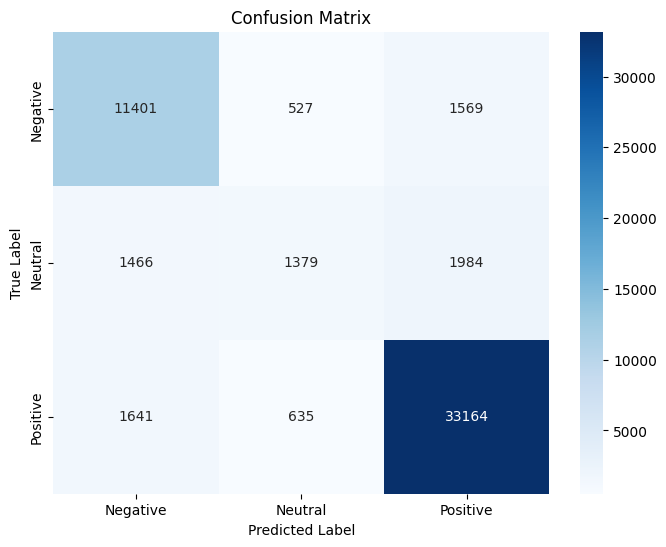

              precision    recall  f1-score   support

           0       0.79      0.84      0.81     13497
           1       0.54      0.29      0.37      4829
           2       0.90      0.94      0.92     35440

    accuracy                           0.85     53766
   macro avg       0.74      0.69      0.70     53766
weighted avg       0.84      0.85      0.84     53766

Micro-average F1 score: 0.8545177249562921


In [ ]:
y_pred_prob = model.predict(X_test_pad)
y_pred_labels = y_pred_prob.argmax(axis=1)
cm = confusion_matrix(y_test, y_pred_labels)
labels = ['Negative', 'Neutral', 'Positive']

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels, ax=ax)

ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

plt.show()

print(classification_report(y_test, y_pred_labels))

micro_avg_f1 = f1_score(y_test, y_pred_labels, average='micro')
print("Micro-average F1 score:", micro_avg_f1)

#With batch normalization

In [ ]:
X_train_pad = pad_sequences(sequences_train, maxlen=250, padding='post', truncating='post')
X_val_pad = pad_sequences(sequences_val, maxlen=250, padding='post', truncating='post')
X_test_pad = pad_sequences(sequences_test, maxlen=250, padding='post', truncating='post')

num_words = min(30000, len(tokenizer.word_index) + 1)
embedding_matrix = np.zeros((num_words, 300))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_dim = 300
sequence_input = Input(shape=(250,))
embedding_layer = Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=250, trainable=False)
embedded_sequences = embedding_layer(sequence_input)
drop_out_1 = Dropout(0.3, name='drop_out_1')(embedded_sequences)
conv_1 = Conv1D(64, 2, activation='relu', name='conv_1')(drop_out_1)
bn_1 = BatchNormalization()(conv_1)
gmp_1 = GlobalMaxPooling1D(name='gmp_1')(bn_1)
conv_2 = Conv1D(64, 3, activation='relu', name='conv_2')(drop_out_1)
bn_2 = BatchNormalization()(conv_2)
gmp_2 = GlobalMaxPooling1D(name='gmp_2')(bn_2)
conv_3 = Conv1D(64, 5, activation='relu', name='conv_3')(drop_out_1)
bn_3 = BatchNormalization()(conv_3)
gmp_3 = GlobalMaxPooling1D(name='gmp_3')(bn_3)
concat = Concatenate()([gmp_1, gmp_2, gmp_3])
drop_out_2 = Dropout(0.3, name='drop_out_2')(concat)
dense = Dense(128, activation='relu', name='dense')(drop_out_2)
preds = Dense(3, activation='softmax', name='preds')(dense)
model = Model(sequence_input, preds)

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(patience=10)

history = model.fit(X_train_pad, y_train, validation_data=(X_val_pad, y_val), epochs=200, batch_size=200, callbacks=[early_stopping])

Epoch 1/200
686/686 [==============================] - 6s 8ms/step - loss: 0.9311 - accuracy: 0.6581 - val_loss: 0.6662 - val_accuracy: 0.7511
Epoch 2/200
686/686 [==============================] - 5s 7ms/step - loss: 0.6793 - accuracy: 0.7330 - val_loss: 0.6088 - val_accuracy: 0.7773
Epoch 3/200
686/686 [==============================] - 5s 7ms/step - loss: 0.6279 - accuracy: 0.7588 - val_loss: 0.5581 - val_accuracy: 0.7907
Epoch 4/200
686/686 [==============================] - 5s 7ms/step - loss: 0.6009 - accuracy: 0.7697 - val_loss: 0.5415 - val_accuracy: 0.7967
Epoch 5/200
686/686 [==============================] - 5s 7ms/step - loss: 0.5785 - accuracy: 0.7780 - val_loss: 0.5345 - val_accuracy: 0.8010
Epoch 6/200
686/686 [==============================] - 5s 7ms/step - loss: 0.5631 - accuracy: 0.7856 - val_loss: 0.5148 - val_accuracy: 0.8050
Epoch 7/200
686/686 [==============================] - 5s 7ms/step - loss: 0.5482 - accuracy: 0.7909 - val_loss: 0.5061 - val_accuracy: 0.8091

1681/1681 [==============================] - 3s 2ms/step


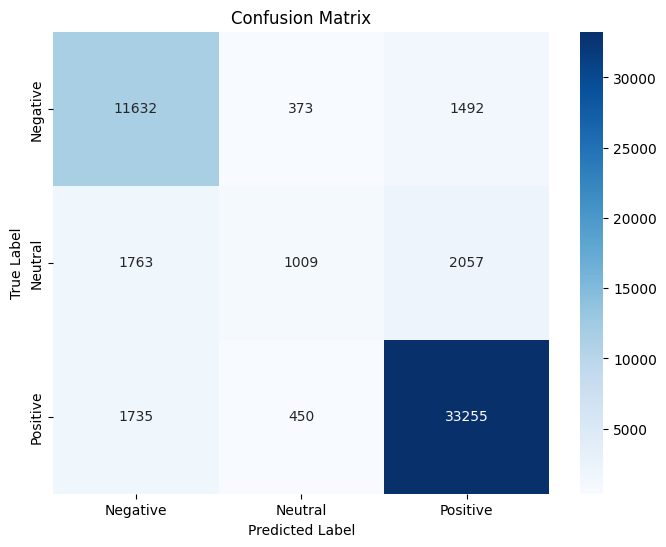

              precision    recall  f1-score   support

           0       0.77      0.86      0.81     13497
           1       0.55      0.21      0.30      4829
           2       0.90      0.94      0.92     35440

    accuracy                           0.85     53766
   macro avg       0.74      0.67      0.68     53766
weighted avg       0.84      0.85      0.84     53766



In [ ]:
y_pred_prob = model.predict(X_test_pad)
y_pred_labels = y_pred_prob.argmax(axis=1)
cm = confusion_matrix(y_test, y_pred_labels)
labels = ['Negative', 'Neutral', 'Positive']

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels, ax=ax)

ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

plt.show()

print(classification_report(y_test, y_pred_labels))

In [ ]:
micro_avg_f1 = f1_score(y_test, y_pred_labels, average='micro')
print("Micro-average F1 score:", micro_avg_f1)

Micro-average F1 score: 0.8536249674515493
